In [21]:
import pandas as pd
import csv

In [22]:
dataset = pd.read_csv('regression_dataset.csv', sep=";")

In [23]:
dataset

,Unnamed: 0,contract,district,renting_type,surface,locals,floor,property_type,price,spese condominio,other_expences,building_year,status,heating,air_conditioning,energy_certificate,parking_slots,heating_expences,heating_system,announce_link
0,0,"Affitto, Libero",barriera-di-milano,Classe immobile signorile,40,2.0,1°,Intera proprietà,390,35.0,NaN,NaN,buono/abitabile,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/89593419/
1,1,"Affitto, Concordato",barriera-di-milano,Classe immobile signorile,40,1.0,Piano,Intera proprietà,330,70.0,NaN,2010.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/89574715/
2,2,"Affitto, 3+2",barriera-di-milano,Classe immobile signorile,50,2.0,"2°,",Intera proprietà,290,60.0,NaN,1900.0,buono/abitabile,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/89563675/
3,3,"Affitto, Libero",barriera-di-milano,Classe immobile signorile,40,1.0,"2°,",Classe immobile signorile,300,NaN,NaN,1900.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/89550347/
4,4,"Affitto, Libero",barriera-di-milano,Classe immobile signorile,50,2.0,"2°,",Classe immobile signorile,350,NaN,NaN,1900.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/89550449/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5511,5511,"Affitto, 4+4",centro,Classe immobile signorile,55,2.0,"4°,",Intera proprietà,750,110.0,NaN,1850.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/34962006/
5512,5512,"Affitto, 4+4",centro,Classe immobile signorile,45,1.0,"2°,",Intera proprietà,550,90.0,NaN,1850.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/34937794/
5513,5513,Affitto,centro,Classe immobile signorile,30,1.0,4°,NaN,320,30.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,centralizzato,https://www.immobiliare.it/annunci/33551654/
5514,5514,"Affitto, 4+4",centro,Classe immobile signorile,45,2.0,Piano,Classe immobile signorile,400,30.0,NaN,1850.0,ottimo/ristrutturato,NaN,None,NaN,NaN,NaN,autonomo,https://www.immobiliare.it/annunci/27293814/


In [24]:
dataset.drop(columns='renting_type', inplace=True)

In [25]:
dataset.dtypes

Unnamed: 0              int64
contract               object
district               object
surface                object
locals                float64
floor                  object
property_type          object
price                  object
spese condominio      float64
other_expences        float64
building_year         float64
status                 object
heating               float64
air_conditioning       object
energy_certificate    float64
parking_slots         float64
heating_expences      float64
heating_system         object
announce_link          object
dtype: object

In [26]:
#dataset.drop(columns='Unnamed: 0', inplace=True)
dataset['floor']= dataset['floor'].str.replace('\W', '')
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)
dataset = dataset[dataset.price != 'Affitto\n                                                                                    750/mese\n                                        ']
dataset = dataset[dataset.price != 'Affitto\n                                                                                    500/mese\n                                        ']
dataset = dataset[dataset.locals != 'C']
dataset = dataset[dataset.price != 'prezzo su richiesta']
dataset = dataset[dataset.surface != '250, terreno di proprietà 2.000']
dataset = dataset[dataset.surface != '100, terreno di proprietà 200']
dataset = dataset[dataset.surface != '160, terreno di proprietà 400']
dataset = dataset[dataset.surface != '165, terreno di proprietà 450']
dataset = dataset[dataset.surface != '105, terreno di proprietà 100']
dataset = dataset[dataset.surface != '130, terreno di proprietà 180']
dataset = dataset[dataset.price != 'Affitto\n                                                                                    450/mese\n                                        ']
dataset = dataset[dataset.locals != 'c']

In [27]:
dataset.fillna(value=0, inplace=True)

In [28]:
dataset.to_csv('before_regression.csv', sep=';')

## 
## PYCARET

In [10]:
from pycaret.regression import *
import pandas as pd

In [29]:
dataset = pd.read_csv('before_regression.csv', sep=";")
dataset['floor']= dataset['floor'].str.replace('\W', '')
dataset = dataset[dataset['price']!='Prezzo su richiesta']
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset.fillna(0, inplace=True)

metri = []

for elem in dataset['surface']:
    if len(elem)>3:
        metri.append(elem[0:3])
    else:
        metri.append(elem)
        
dataset['surface'] = metri
dataset['price'] = dataset['price'].astype(int)
#dataset['Price'] = (dataset['Prezzo'].astype(int) + dataset['Spese condominio'].astype(int) + dataset['Spese riscaldamento'].astype(int))
dataset['locals'] = dataset['locals'].astype(int)
dataset['surface'] = dataset['surface'].astype(int)
dataset = dataset[dataset['price']<1000]
dataset.to_csv('dataset_lower_then_1000.csv', sep=';')
dati = dataset.drop(columns= ['spese condominio', 'heating_expences', 'other_expences', 'energy_certificate'])

In [30]:
exp_reg101 = setup(data = dati.drop(columns=['announce_link', 'Unnamed: 0.1']), target = 'price', categorical_features = ['contract', 'district', 'floor', 'property_type', 'building_year', 'air_conditioning'], numeric_features=['locals','surface'], remove_outliers= False) 

,Description,Value
0,session_id,1577
1,Target,price
2,Original Data,"(4959, 13)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3471, 226)"


In [31]:
compare_models(exclude=['lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,69.4352,9395.7538,96.7572,0.6549,0.2266,0.1430,1.5290
lightgbm,Light Gradient Boosting Machine,71.7548,10030.0414,99.9571,0.6317,0.2589,0.1466,0.1760
xgboost,Extreme Gradient Boosting,71.3099,10020.4459,99.8918,0.6317,0.2153,0.1469,1.1120
gbr,Gradient Boosting Regressor,73.7200,10277.2365,101.2169,0.6224,0.2581,0.1519,0.4130
rf,Random Forest Regressor,72.4177,10393.2886,101.8163,0.6180,0.2055,0.1481,0.8510
et,Extra Trees Regressor,72.6233,10703.1091,103.2845,0.6069,0.2080,0.1489,1.2700
br,Bayesian Ridge,75.8000,11100.2705,105.1056,0.5923,0.2595,0.1582,0.0930
ridge,Ridge Regression,76.0374,11158.3579,105.4045,0.5901,0.2517,0.1593,0.0210
huber,Huber Regressor,75.6803,11475.6194,106.8258,0.5784,0.2586,0.1567,0.8190
omp,Orthogonal Matching Pursuit,78.1884,11690.7022,107.8607,0.5706,0.2499,0.1636,0.0220


In [32]:
model = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,64.4546,8236.3811,90.7545,0.6791,0.3201,0.1436
1,66.2052,8610.3507,92.7920,0.6601,0.3785,0.1373
2,69.7721,9364.7642,96.7717,0.6667,0.1817,0.1393
3,71.1423,9636.9228,98.1678,0.6563,0.1918,0.1489
4,63.5790,8099.1453,89.9953,0.6944,0.1743,0.1287
5,68.4000,9326.7833,96.5753,0.6523,0.1841,0.1407
6,71.5049,8693.8748,93.2410,0.6759,0.1828,0.1460
7,75.2232,11193.1906,105.7979,0.5979,0.1977,0.1490
8,75.9358,11797.9349,108.6183,0.5928,0.2743,0.1601
9,68.1354,8998.1899,94.8588,0.6731,0.1808,0.1361


In [33]:
tuned_model = tune_model(model, n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,66.2323,8477.8748,92.0754,0.6697,0.3140,0.1480
1,69.0344,9209.7316,95.9673,0.6364,0.3775,0.1427
2,72.7549,10659.5942,103.2453,0.6207,0.1931,0.1445
3,73.6130,9975.1145,99.8755,0.6442,0.1958,0.1548
4,64.9845,8308.3968,91.1504,0.6865,0.1790,0.1325
5,70.1209,9291.4607,96.3922,0.6536,0.1862,0.1453
6,75.8652,9880.5647,99.4010,0.6317,0.1948,0.1550
7,75.8447,11589.1502,107.6529,0.5836,0.2024,0.1512
8,77.4072,11921.9073,109.1875,0.5886,0.2991,0.1629
9,70.7523,9714.9741,98.5646,0.6471,0.2364,0.1399


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

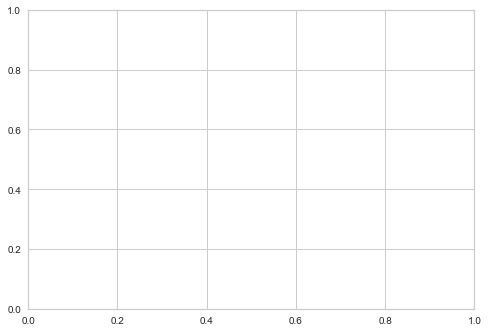

In [34]:
evaluate_model(tuned_model)

In [44]:
predict_model(tuned_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,71.5023,9412.2625,97.0168,0.6703,0.2076,0.1446


In [45]:
final_model = finalize_model(tuned_model)
print(final_model)
predict_model(final_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,61.8236,6933.7266,83.2690,0.7571,0.1822,0.1262


In [46]:
save_model(final_model,'Final Model 21072021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['contract',
                                                             'district', 'floor',
                                                             'property_type',
                                                             'building_year',
                                                             'air_conditioning'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['locals', 'surface'],
                                       target='price', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target

In [47]:
predictions = predict_model(final_model, data=dati.drop(columns=['announce_link', 'Unnamed: 0.1']))

In [48]:
predictions.reset_index(inplace=True)

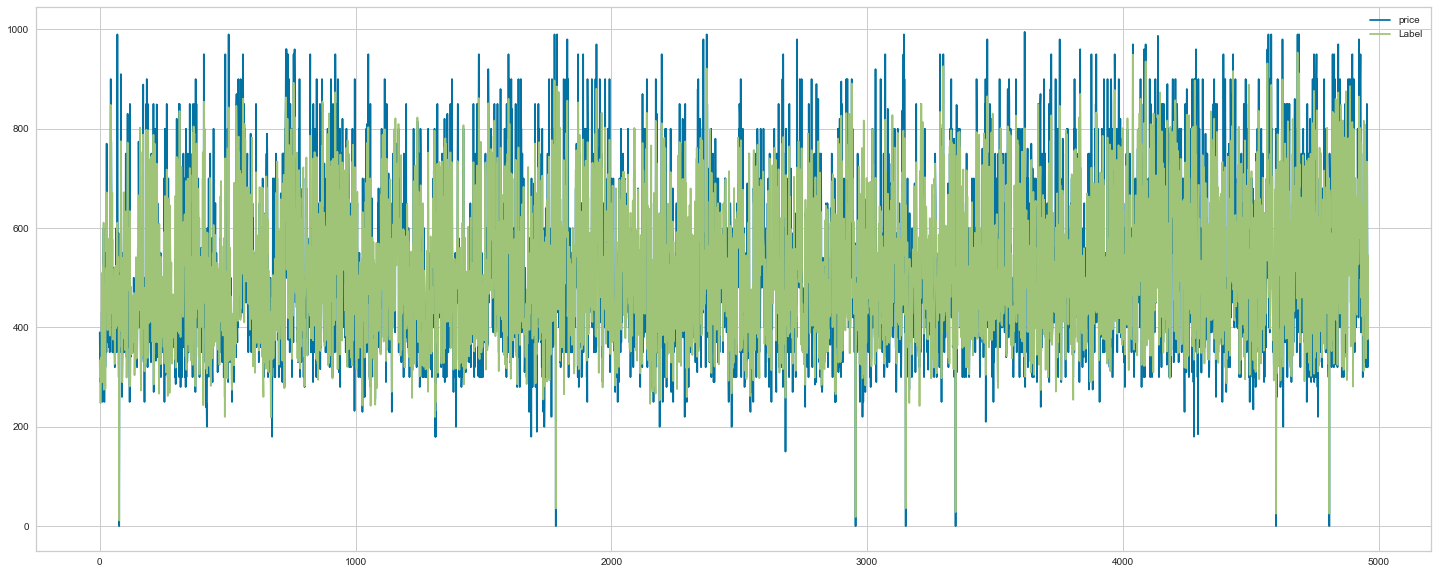

In [49]:
predictions = predictions[predictions['price']<1000]
plt = predictions[['price', 'Label']].plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig("risultato_pycaret.png")
fig.savefig("risultato_pycaret.svg")

In [50]:
import scipy
scipy.stats.pearsonr(predictions['price'], predictions['Label'])[0]

0.8685163698351128

<AxesSubplot:>

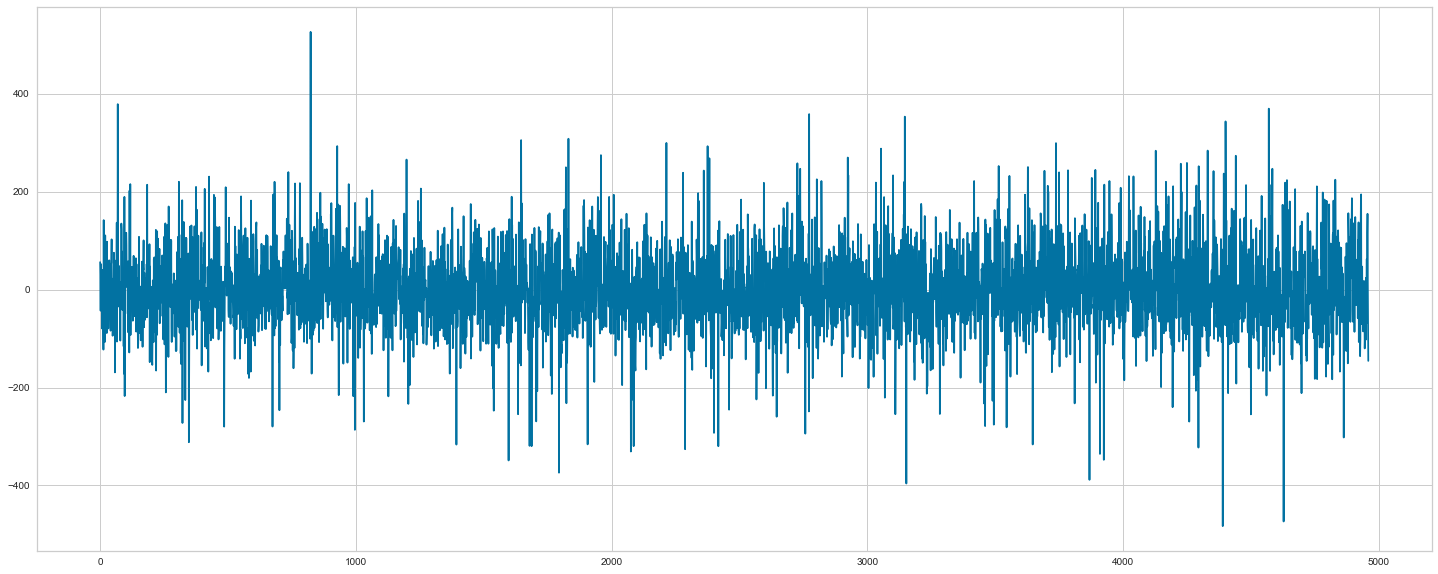

In [51]:
(predictions['price'] - predictions['Label']).plot(figsize=(25,10))

In [52]:
predictions['links'] = dati.reset_index()['announce_link']

In [53]:
predictions.to_csv('predictions_PYCARET.csv')